In [1]:
%matplotlib inline
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline

import custom_helpers as ch

np.random.seed(0)

# print(df.info())

In [2]:
#non sample-dependent transformations
def sample_agnostic_transformation(data):

    selected_col = [
                'homebanking_active'
                # 'has_homebanking'
                ,'bal_mortgage_loan'
                ,'has_life_insurance_decreasing_cap'
                    # # ,'has_mortgage_loan'
                ,'has_current_account'
                    # ,'cap_life_insurance_decreasing_cap'
                ,'bal_savings_account'
                # ,'bal_current_account'
                ,'has_personal_loan'
                    # ,'bal_personal_loan'
                ,'customer_since_all_years'
                    # ,'customer_since_bank_years'
                ,'customer_age'
                ,'customer_children'
                ,'customer_education'
                # ,'has_current_account_starter'
                # ,'has_savings_account'
                ,'visits_distinct_so'
                ,'customer_self_employed'
                # ,'customer_gender'
         ]
    
    if 'target' in data.columns:
        y = data.target
        X = data.drop(columns = ['target'])
        X = X[selected_col]
    else:
        X = data[selected_col]
        y = 0
        
    X['age2'] = data['customer_age']*data['customer_age']
    
    X['interaction'] = data['visits_distinct_so']*data['customer_since_all_years']
    # X['interaction'] = data['visits_distinct_so']*data['customer_self_employed']

    return X, y

df = ch.load_data('../data/train_month_3_with_target.csv')
X, y = sample_agnostic_transformation(df)
X.info()

------------------------------------------------------------
loading data...
transforming dates...
cast types into bool, object, categorical...
data loaded and casted
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63697 entries, 0 to 63696
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   homebanking_active                 63697 non-null  bool    
 1   bal_mortgage_loan                  63697 non-null  int64   
 2   has_life_insurance_decreasing_cap  63697 non-null  bool    
 3   has_current_account                63697 non-null  bool    
 4   bal_savings_account                63697 non-null  int64   
 5   has_personal_loan                  63697 non-null  bool    
 6   customer_since_all_years           63463 non-null  float64 
 7   customer_age                       63697 non-null  int64   
 8   customer

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state=42)

from sklearn.compose import make_column_selector

num_col = make_column_selector(dtype_include = 'number', dtype_exclude = 'bool')
cat_col = make_column_selector(dtype_include = 'category')
bool_col = make_column_selector(dtype_include = 'bool')
date_col = make_column_selector(dtype_include = 'datetime64')
obj_col = make_column_selector(dtype_include = 'object')

In [4]:
from sklearn.preprocessing import FunctionTransformer

numeric_transformer = Pipeline(steps = [
    ('impute',SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop = 'first',handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_ID','drop',obj_col),
        ('drop_dates','drop',date_col),
        ('cat',categorical_transformer,cat_col),
        ('num',numeric_transformer,num_col)
    ],
    remainder = "passthrough"
)

f = preprocessor.fit_transform(X_train)
f = pd.DataFrame(f)

In [5]:
lr = LogisticRegression(max_iter=10000, tol=0.5, class_weight = 'balanced')

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("logistic", lr)]
)

param_grid = {
        "logistic__C": np.logspace(-10,3,10)
    }

gridscorer = ch.gridscorer() # customer scorer (precision@250)

search = GridSearchCV(pipe, param_grid, scoring = gridscorer, n_jobs=-2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

clf = search.best_estimator_.fit(X_train,y_train)

# make prediction on test

ch.evaluate(clf, X_test, y_test)

Best parameter (CV score=29.400):
{'logistic__C': 0.0016681005372000592}
------------------------------------------------------------
Performance Over Whole Set
------------------------------------------------------------
               precision    recall  f1-score   support

Did not Churn       0.98      0.67      0.80     20390
        Churn       0.06      0.64      0.11       631

     accuracy                           0.67     21021
    macro avg       0.52      0.66      0.45     21021
 weighted avg       0.96      0.67      0.78     21021

------------------------------------------------------------
AUC: 0.66
No. of TP (precision@250): 42
------------------------------------------------------------


------------------------------------------------------------
loading data...
transforming dates...
cast types into bool, object, categorical...
data loaded and casted
------------------------------------------------------------


/var/folders/k9/8r2lz4cj6qv_gpslncglrtc40000gn/T/ipykernel_53366/1856144008.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age2'] = data['customer_age']*data['customer_age']
/var/folders/k9/8r2lz4cj6qv_gpslncglrtc40000gn/T/ipykernel_53366/1856144008.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = data['visits_distinct_so']*data['customer_since_all_years']


[[ 0.09277067 -0.09724924 -0.0770966  -0.01497808  0.08354551  0.04734683
   0.04223512  0.09730973  0.1426577   0.13792625  0.2582035   0.0929976
   0.15248753  0.01929856  0.10450055 -0.35673494  0.02361204  0.15959858
   0.02858001 -0.29693358 -0.05503322  0.30240344  0.24409149  0.57672766
   0.17854116  0.1237756 ]]


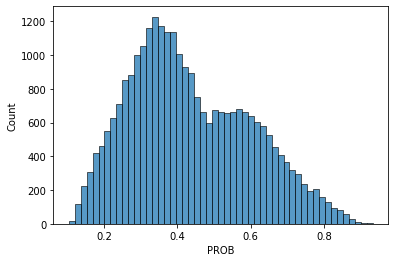

In [6]:
# run on submission data
data_sub = ch.load_data('../data/test_month_3.csv')
X_sub, y_sub = sample_agnostic_transformation(data_sub)

# make prediction on test
y_pred_test_sub_pos = clf.predict_proba(X_sub)[:,1]

df = pd.DataFrame({'ID': data_sub.client_id,'PROB':y_pred_test_sub_pos})
today = dt.datetime.today()
df.to_csv(f'../output/lrint_{today.month}{today.day}.csv', index = False)
sns.histplot(df['PROB'])
print(clf['logistic'].coef_)

In [10]:
from sklearn import set_config
set_config(display="diagram")
search

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_ID', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbaedf7a6a0>),
                                                 ('drop_dates', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbaee5bd850>),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbaee5bd8e0>),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbaee5bda30>)])),
                ('logistic',
                 LogisticRegression(C=0.0016681005372000592,
                                    class_weight='balanced', max_iter=10000,
                                    tol=0.5))])